In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
from skimage import exposure
from skimage import filters
from scipy import ndimage
import scipy.io

import pims
import trackpy as tp

from os import path


In [2]:
bench_mark_file_list = ['benchmark_ti_1.cine',
                        'benchmark_ti_2.cine',
                        'benchmark_ti_3.cine',
                        'benchmark_ti_4.cine']

ultrasound_file_list = ['round_1_17V_Ti.cine',
                        'round_2_17V_Ti.cine',
                        'round_3_17V_Ti.cine',
                        'round_4_17V_Ti.cine']

bench_mark = [pims.open(path.join('.','video',f_name)) for f_name in bench_mark_file_list]
ultrasound = [pims.open(path.join('.','video',f_name)) for f_name in ultrasound_file_list]

In [3]:
min_frame = np.Inf

for vid in bench_mark:
    if(len(vid) < min_frame):
        min_frame = len(vid)

for vid in ultrasound:
    if(len(vid) < min_frame):
        min_frame = len(vid)
min_frame

51834

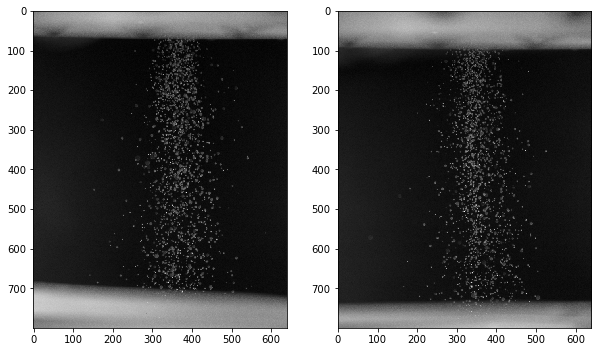

In [4]:
fig, axs = plt.subplots( 1, 2, figsize = (10,10))
axs[0].imshow(bench_mark[0][0], cmap = 'gray')
axs[1].imshow(ultrasound[0][0], cmap = 'gray')
plt.show()

In [5]:
sampled_frame = np.arange(0, min_frame-100, 5)

In [6]:
@pims.pipeline
def crop_top(image):
    return image[150:650,:]

test_bench = crop_top(bench_mark[0])
test_ultrasound = crop_top(ultrasound[0])

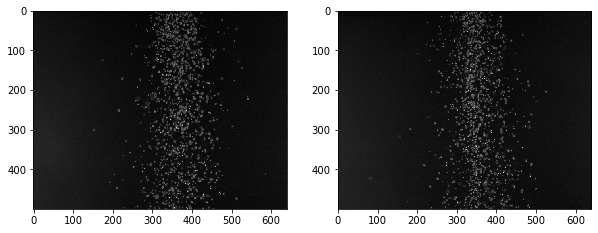

In [7]:
fig, axs = plt.subplots( 1, 2, figsize = (10,10))
axs[0].imshow(test_bench[0], cmap = 'gray')
axs[1].imshow(test_ultrasound[0], cmap = 'gray')
plt.show()

In [8]:
from skimage import restoration
from skimage import morphology

@pims.pipeline
def denoise_nl(image):
    sig = restoration.estimate_sigma(image,average_sigmas = True)
    return restoration.denoise_nl_means(image, sigma = sig)

@pims.pipeline
def denoise_median(image):
    selem = morphology.disk(3)
    return filters.median(image, selem)

In [9]:
@pims.pipeline
def binarise_otsu(image):
    thresh = filters.threshold_otsu(image)
    return (thresh <= image).astype(int)

@pims.pipeline
def binarise_half_way(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return ((min_val+(max_val-min_val)*0.25) <= image).astype(int)

binary_vid_bench_alt = binarise_half_way(test_bench)
binary_vid_ultrasound_alt = binarise_half_way(test_ultrasound)

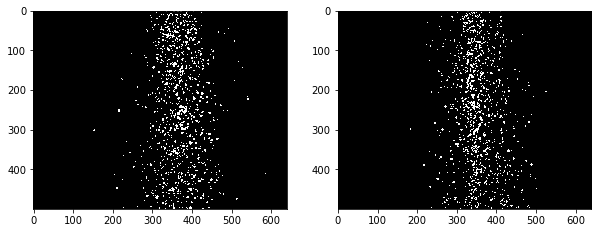

In [10]:
fig, axs = plt.subplots( 1, 2, figsize = (10,10))
axs[0].imshow(binary_vid_bench_alt[0],cmap = 'gray')
axs[1].imshow(binary_vid_ultrasound_alt[0],cmap = 'gray')
plt.show()

In [11]:
from skimage import measure
import pandas as pd

@pims.pipeline
def avg_pix_area(image):
    labeled_im = morphology.label(image, connectivity = 1)
    region_props = measure.regionprops(labeled_im)
    area_list = [reg.area for reg in region_props]
    return (np.mean(area_list),np.std(area_list))

In [13]:
import time

start = time.process_time() 
def compute_avg_blob_size(im_list, sampled_frame):

    df_otsu = pd.DataFrame(columns=["file","frame",'mean area', 'std'])
    df_half = df_otsu.copy()
    
    for i, b_im in enumerate(im_list):
        cropped_im = crop_top(b_im)
        binary_vid_otsu = binarise_otsu(cropped_im)
        binary_vid_half = binarise_half_way(cropped_im)

        for f in sampled_frame:
            avg_blob_otsu = avg_pix_area(binary_vid_otsu)[f]
            avg_blob_half = avg_pix_area(binary_vid_otsu)[f]
            
            df_otsu = df_otsu.append({'file':i, 'frame': f, 
                                     'mean area': avg_blob_otsu[0],
                                     'std' : avg_blob_otsu[1]}, ignore_index = True)
            df_half = df_half.append({'file':i, 'frame': f, 
                                     'mean area': avg_blob_half[0],
                                     'std' : avg_blob_half[1]}, ignore_index = True)
            
        
    return (df_otsu,df_half)


data_bench = compute_avg_blob_size(bench_mark,sampled_frame)

end = time.process_time() 

print('processing time: {}'.format(end-start))

processing time: 1814.546875


In [16]:
data_bench[0].to_csv('./video/blob_otsu_bench.csv')
data_bench[1].to_csv('./video/blob_half_bench.csv')

In [17]:
data_ultrasound = compute_avg_blob_size(ultrasound,sampled_frame)
data_ultrasound[0].to_csv('./video/blob_otsu_ultrasound.csv')
data_ultrasound[1].to_csv('./video/blob_half_ultrasound.csv')

In [21]:
data_otsu_mean_bench = data_bench[0].groupby(['file']).mean().drop(columns=['frame','std'])
data_half_mean_bench = data_bench[1].groupby(['file']).mean().drop(columns=['frame','std'])

In [22]:
data_otsu_mean_ultra = data_ultrasound[0].groupby(['file']).mean().drop(columns=['frame','std'])
data_half_mean_ultra = data_ultrasound[1].groupby(['file']).mean().drop(columns=['frame','std'])

In [24]:
data_otsu_mean_bench.to_csv('./video/blob_otsu_bench_mean.csv')
data_half_mean_bench.to_csv('./video/blob_half_bench_mean.csv')

In [25]:
data_otsu_mean_ultra.to_csv('./video/blob_otsu_ultra_mean.csv')
data_half_mean_ultra.to_csv('./video/blob_half_ultra_mean.csv')